In [59]:
from dotenv import load_dotenv
env = load_dotenv()

In [60]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from IPython.display import Image
import IPython

In [ ]:
# RAG 

In [61]:
from typing import TypedDict, Annotated, Dict, Any
import operator

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    # output: str

In [62]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults()

In [63]:
# Download PDF tool
from langchain.tools import tool
from langchain.pydantic_v1 import BaseModel, Field
from urllib.request import urlopen

class SearchInput(BaseModel):
    download_url: str = Field(description="the URL of the menu pdf")
    filename: str = Field(description="the name of the restaurants")

@tool("download-pdf", args_schema=SearchInput, return_direct=True)
def download_pdf(download_url: str, filename: str):
    """Download a pdf file from a given url and filename"""
    response = urlopen(download_url)
    file = open("pdf/"+filename+".pdf", 'wb')
    file.write(response.read())
    file.close()

In [64]:
tools = [search_tool, download_pdf]

In [ ]:
class Model:
    # Define the model
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.classify)
        graph.add_node("action", self.take_action)
        #graph.add_node("output-parser", self.classify)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    # Check if llm requires action 
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    # Run a tool ordered by the model
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
    # Perform inference on the gathered context
    def classify(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    # def parse_output_to_string(self, state: AgentState):
    #     message = state['messages'][-1]
    #     json_output = JsonOutputParser(pydantic_object=Restaurants).invoke(message)
    #     return {'json_output': json_output}

In [74]:
prompt = """You are an AI tasked with finding and downloading a PDF of the menu for a given restaurant. 
Use the search tool to find the url of a pdf menu, if found use the pdf download tool to download it.
Once you have downloaded the PDF there are no more tasks to be done. 
DO NOT respond as an AI assistant, only name and save the menu as a pdf after it's been found. 
"""

# llm = OllamaFunctions(
#     model="phi3", 
#     keep_alive=-1,
#     format="json"
# )

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
)

model = Model(llm, tools, system=prompt)

ImportError: cannot import name 'tool_call_chunk' from 'langchain_core.messages.tool' (/home/rwalling/.local/lib/python3.10/site-packages/langchain_core/messages/tool.py)

In [72]:
messages = ["CRISP Rochester"]
result = model.graph.invoke({"messages": ["CRISP Rochester"]})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Rochester restaurant menus PDF'}, 'id': 'call_9281f072029e436cbb74712063014816'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Rochester restaurant menu'}, 'id': 'call_876e17e5c9a14b5a8c0b6ad1f0a617d3'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'title': 'TavilyInput', 'description': 'Input for the Tavily tool.', 'type': 'object', 'properties': {'query': {'title': 'Query', 'description': "search query to look up in Rochester, NY restaurant menus and descriptions. Should be a string related to 'CRISP ROCHESTER' for the best results.", 'type': 'string'}}, 'required': ['query']}, 'id': 'call_0e0910c363cf4403b4b2effff612eccb'}


ValidationError: 1 validation error for TavilyInput
query
  field required (type=value_error.missing)

In [ ]:
result

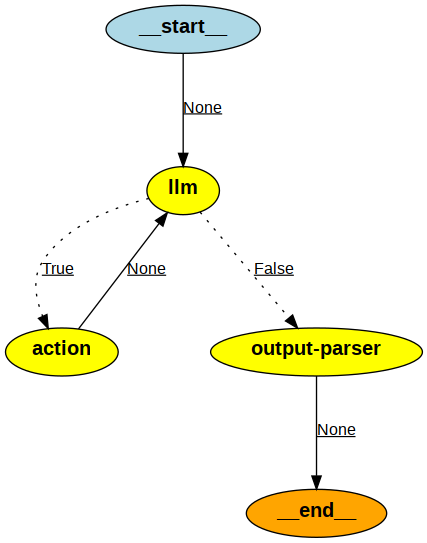

In [30]:
import pygraphviz
Image(model.graph.get_graph().draw_png())

In [ ]:
# Datastore

In [ ]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()

pc.create_index(
    name="quickstart",
    dimension=5120, # Lamma 2 embedding dim
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)